In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from tqdm.auto import tqdm  # Use .auto for best support in Jupyter/Notebooks

MODEL_NAMES = ["efficientnet_b0_finetuned_larger_batch", "efficientnet_b0_finetuned_larger_batch_no_padding", "efficientnet_b0_finetuned_no_padding"]

# Experiments Results and Comaprison

## Accuracy

Loaded: efficientnet_b0_finetuned_larger_batch
Loaded: efficientnet_b0_finetuned_larger_batch_no_padding
Loaded: efficientnet_b0_finetuned_no_padding


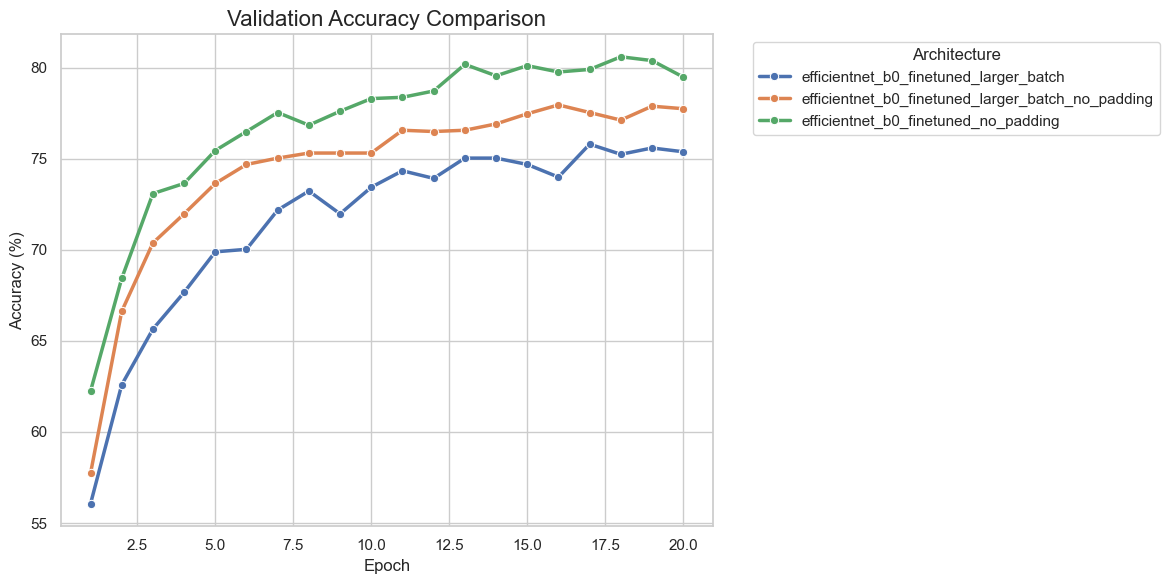

In [33]:
# Set plot style
sns.set_theme(style="whitegrid")

project_root = Path.cwd().parent 
results_root = project_root / "results" / "experiments"

all_data = []

for model in MODEL_NAMES:
    csv_path = results_root / model / "metrics.csv"
    
    if csv_path.exists():
        df = pd.read_csv(csv_path)
        df['model'] = model
        all_data.append(df)
        print(f"Loaded: {model}")
    else:
        print(f"Not found: {csv_path.resolve()}")

comparison_df = pd.concat(all_data, ignore_index=True) if all_data else None

plt.figure(figsize=(12, 6))
sns.lineplot(data=comparison_df, x='epoch', y='val_acc', hue='model', marker='o', linewidth=2.5)

plt.title('Validation Accuracy Comparison', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(title='Architecture', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Loss

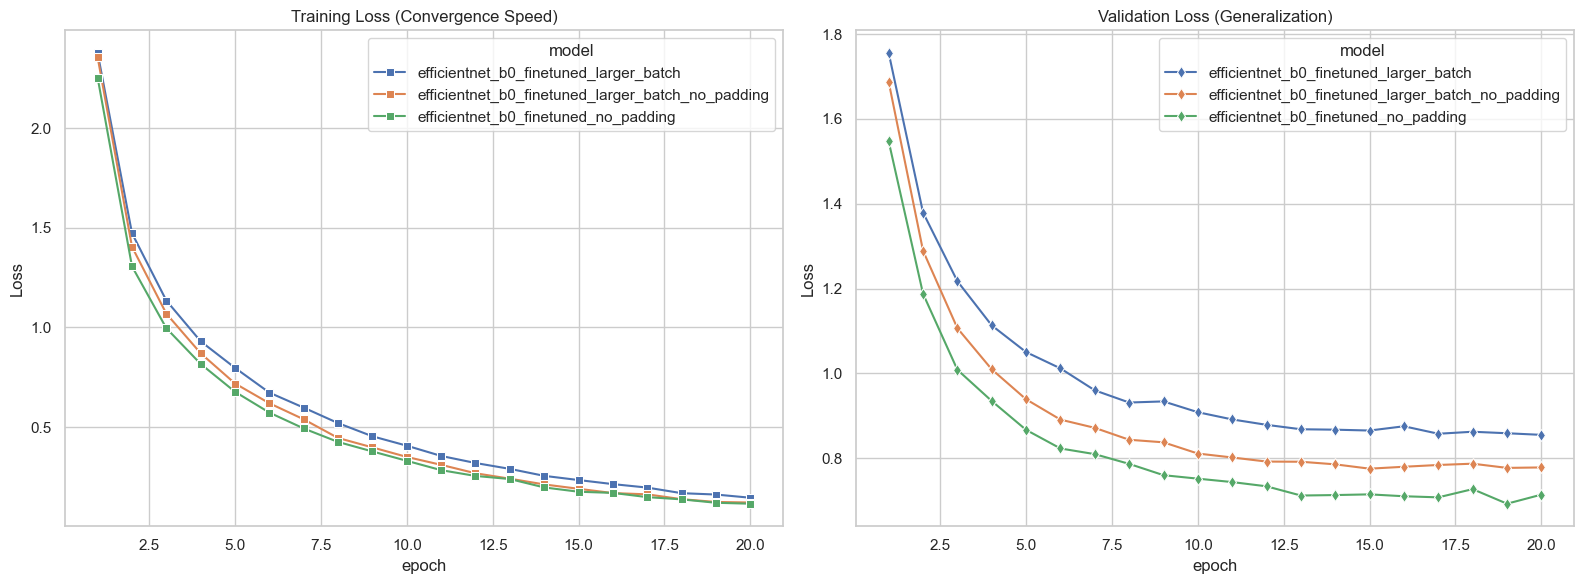

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training Loss
sns.lineplot(ax=axes[0], data=comparison_df, x='epoch', y='train_loss', hue='model', marker='s')
axes[0].set_title('Training Loss (Convergence Speed)')
axes[0].set_ylabel('Loss')

# Validation Loss
sns.lineplot(ax=axes[1], data=comparison_df, x='epoch', y='val_loss', hue='model', marker='d')
axes[1].set_title('Validation Loss (Generalization)')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [7]:
summary = comparison_df.groupby('model')['val_acc'].max().sort_values(ascending=False)
print("--- Final Best Accuracy per Model ---")
print(summary.to_string())

--- Final Best Accuracy per Model ---
model
efficientnet_b0_finetuned_no_padding                 80.598053
efficientnet_b0_finetuned_larger_batch_no_padding    77.955494
efficientnet_b0_finetuned_larger_batch               75.799722


## Confusion Matrix

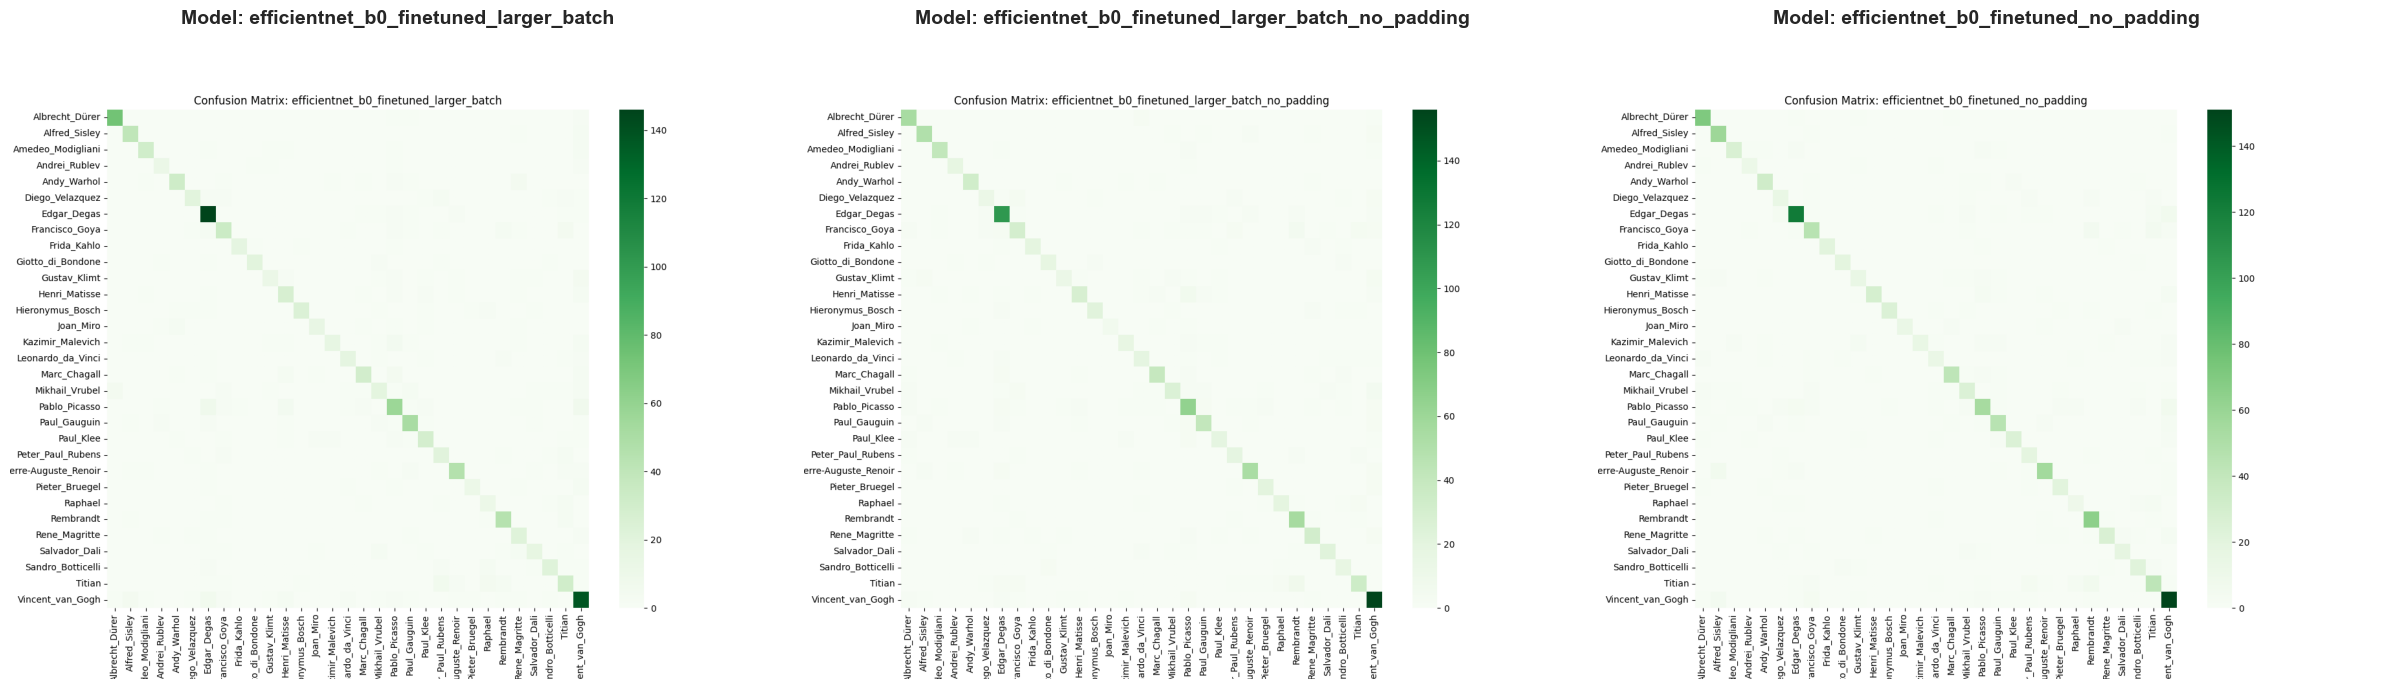

In [ ]:
# Create a figure with subplots (1 rows, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Flatten the axes so we can iterate with a single index i
axes_flat = axes.flatten()

for i, model in enumerate(MODEL_NAMES):
    cm_path = project_root / "results" / "charts" / "experiments" /model /"confusion_matrix.png"
    if cm_path.exists():
        img = mpimg.imread(cm_path)
        # Use the flattened array here
        axes_flat[i].imshow(img)
        axes_flat[i].set_title(f"Model: {model}", fontsize=14, fontweight='bold')
        axes_flat[i].axis('off')
    else:
        axes_flat[i].text(0.5, 0.5, f"Image Not Found:\n{model}", 
                          ha='center', va='center', fontsize=12, color='red')
        axes_flat[i].axis('off')


plt.tight_layout()
plt.show()

# Metrics with Bootstrap Sampling

In [ ]:
# Setup Absolute Paths
notebooks_dir = Path.cwd().resolve()
project_root = notebooks_dir.parent

# Corrected paths based on your folder structure
MODEL_DIR = project_root / "models" / "experimental" 
DATA_DIR = project_root / "data" / "processed" / "resized224"

BATCH_SIZE = 32
BOOTSTRAP_RATIO = 0.20
NUM_CLASSES = len([d for d in DATA_DIR.iterdir() if d.is_dir()])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Loader Factory
def load_model_architecture(name, checkpoint_path):
    if "resnet50" in name:
        model = models.resnet50()
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif "efficientnet_b0" in name:
        model = models.efficientnet_b0()
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    elif "convnext_tiny" in name:
        model = models.convnext_tiny()
        model.classifier[2] = nn.Linear(model.classifier[2].in_features, NUM_CLASSES)
    else:
        raise ValueError(f"Unknown architecture for {name}")

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    return model.to(device).eval()

# Data Prep (Transform included to avoid TypeError)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(str(DATA_DIR), transform=transform)
indices = np.random.choice(len(full_dataset), int(len(full_dataset) * BOOTSTRAP_RATIO), replace=True)
loader = DataLoader(Subset(full_dataset, indices), batch_size=BATCH_SIZE, shuffle=False)

# 4. Evaluation Loop with tqdm
results = []
for name in MODEL_NAMES:
    path = MODEL_DIR / f"{name}_best.pth"
    if not path.exists():
        print(f"Skipping {name}: Checkpoint not found at {path}")
        continue
    
    model = load_model_architecture(name, path)
    y_true, y_pred = [], []
    
    # Progress bar for batches within each model
    pbar = tqdm(loader, desc=f"Evaluating {name}", unit="batch", leave=False)
    
    with torch.no_grad():
        for imgs, labels in pbar:
            outputs = model(imgs.to(device))
            y_pred.extend(outputs.argmax(1).cpu().numpy())
            y_true.extend(labels.numpy())

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    results.append({"Model": name, "Accuracy": acc, "Precision": p, "Recall": r, "F1": f1})

# Final Table
df = pd.DataFrame(results)
print("\n--- Final Results ---")
print(df.to_string(index=False))

Evaluating efficientnet_b0_finetuned_larger_batch:   0%|          | 0/45 [00:00<?, ?batch/s]

Evaluating efficientnet_b0_finetuned_larger_batch_no_padding:   0%|          | 0/45 [00:00<?, ?batch/s]

Evaluating efficientnet_b0_finetuned_no_padding:   0%|          | 0/45 [00:00<?, ?batch/s]


--- Final Results ---
                                            Model  Accuracy  Precision   Recall       F1
           efficientnet_b0_finetuned_larger_batch  0.872740   0.877499 0.872740 0.869706
efficientnet_b0_finetuned_larger_batch_no_padding  0.958971   0.960004 0.958971 0.958610
             efficientnet_b0_finetuned_no_padding  0.965925   0.966484 0.965925 0.965896
